# Kaggle MNIST Digit Recognition problem

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [2]:
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Importing the dataset
train = pd.read_csv('/data/fashion-mnist_train.csv')
test = pd.read_csv('/data/fashion-mnist_test.csv')
X_train = train.iloc[:, 1::].values
labels_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1::].values
labels_test = test.iloc[:, 0].values

In [5]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [6]:
# Feature Scaling (required for PCA and efficient for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Plotting sample images in test and train

In [7]:
# Reshaping train and test images
images_train = X_train.reshape(X_train.shape[0], 28, 28)
images_test = X_test.reshape(X_test.shape[0], 28, 28)

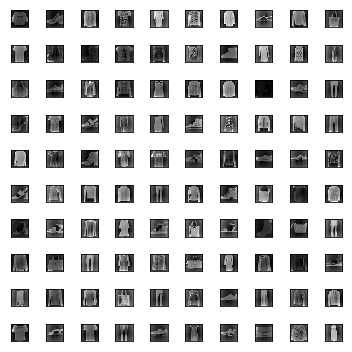

In [8]:
# Train images
plt.figure(figsize = (5, 5))
for i in range(0, 100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images_train[i], interpolation = "none", cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

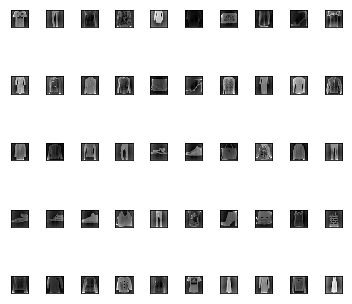

In [9]:
# Test images
plt.figure(figsize = (5, 5))
for i in range(0, 50):
    plt.subplot(5, 10, i+1)
    plt.imshow(images_test[i], interpolation = "none", cmap = "gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [10]:
images_test = np.expand_dims(images_test,1)
images_train = np.expand_dims(images_train,1)

In [11]:
# Encoding for label variable for use in Neural Networks
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categorical_features = [0])
labels_train = onehotencoder.fit_transform(labels_train.reshape(-1,1)).toarray()

In [83]:
np.shape(labels_train), np.shape(labels_test)

((60000, 10), (10000,))

## Neural Network models - CNN and its variants

In [13]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.


### Model 1 : Simple stacked CNN architecture

In [87]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
model.compile(optimizer = 'nadam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 8, 8)          36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
__________

In [89]:
images_train.shape

(60000, 1, 28, 28)

In [94]:
# Fitting the CNN to the Training Set
history = model.fit(images_train, labels_train, validation_split = 0.2, batch_size = 100, epochs = 3)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 12s - loss: 0.0934 - acc: 0.9649 - val_loss: 0.3422 - val_acc: 0.9108
Epoch 2/3
48000/48000 [==============================] - 12s - loss: 0.0868 - acc: 0.9680 - val_loss: 0.3667 - val_acc: 0.9041
Epoch 3/3
48000/48000 [==============================] - 11s - loss: 0.0771 - acc: 0.9721 - val_loss: 0.3993 - val_acc: 0.9025


In [93]:
model.optimizer.lr /= 2

The above two steps were run repeatedly until the model heavily overfitted (trn_acc = 97%, val. acc = 90%). The simple stacked model was run with Nesterov momentum + RMSprop optimizer at learning rates of 0.002, 0.001 and 0.0005 for 4, 3 and 3 epochs respectively. Test accuracy for this model is ~91%

Having overfitted the model, we can now try regularization techniques below.

### Model 2 : Data Augmentation + Dropout

In [70]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.1),
        Dense(10, activation='softmax')
        ])
model.compile(optimizer = 'nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 8, 8)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
__________

In [26]:
from keras.preprocessing import image

In [27]:
images_train = images_train.reshape(images_train.shape[0], 1, 28, 28)

In [28]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(images_train, labels_train, test_size = 0.2)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
X_train.shape

(48000, 1, 28, 28)

In [62]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_train, y_train, batch_size = 128)
val_batches = gen.flow(X_valid, y_valid, batch_size = 256)

In [31]:
val_batches

In [63]:
model.optimizer.lr = 0.005

In [68]:
model.fit_generator(batches, (batches.n/batches.batch_size), epochs=10,
                   validation_data = val_batches, validation_steps = (val_batches.n/val_batches.batch_size))

Epoch 1/10
375/375 [==============================] - 20s - loss: 0.4848 - acc: 0.8254 - val_loss: 0.4678 - val_acc: 0.8302
Epoch 2/10
375/375 [==============================] - 20s - loss: 0.4846 - acc: 0.8240 - val_loss: 0.4515 - val_acc: 0.8334
Epoch 3/10
375/375 [==============================] - 20s - loss: 0.4816 - acc: 0.8253 - val_loss: 0.4565 - val_acc: 0.8342
Epoch 4/10
375/375 [==============================] - 20s - loss: 0.4888 - acc: 0.8214 - val_loss: 0.4589 - val_acc: 0.8292
Epoch 5/10
375/375 [==============================] - 20s - loss: 0.4852 - acc: 0.8255 - val_loss: 0.4602 - val_acc: 0.8347
Epoch 6/10
375/375 [==============================] - 20s - loss: 0.4856 - acc: 0.8262 - val_loss: 0.4569 - val_acc: 0.8349
Epoch 7/10
375/375 [==============================] - 20s - loss: 0.4825 - acc: 0.8264 - val_loss: 0.4663 - val_acc: 0.8244
Epoch 8/10
375/375 [==============================] - 20s - loss: 0.4803 - acc: 0.8278 - val_loss: 0.4498 - val_acc: 0.8309
Epoch 9/

In [67]:
model.optimizer.lr /= 2

In [72]:
def lr_iter(start, stop, div_step) :
    while start >= stop:
        yield start
        start/= div_step

In [74]:
for i in lr_iter(0.005, 0.0005, 2):
    model.optimizer.lr = i
    print ("Learning rate = "+str(i))
    model.fit_generator(batches, (batches.n/batches.batch_size), epochs=20,
                   validation_data = val_batches, validation_steps = (val_batches.n/val_batches.batch_size))

Learning rate = 0.005
Epoch 1/20
375/375 [==============================] - 19s - loss: 0.9705 - acc: 0.6367 - val_loss: 0.7024 - val_acc: 0.7311
Epoch 2/20
375/375 [==============================] - 19s - loss: 0.6448 - acc: 0.7552 - val_loss: 0.5610 - val_acc: 0.7821
Epoch 3/20
375/375 [==============================] - 19s - loss: 0.5792 - acc: 0.7833 - val_loss: 0.5219 - val_acc: 0.8017
Epoch 4/20
375/375 [==============================] - 19s - loss: 0.5434 - acc: 0.7973 - val_loss: 0.5046 - val_acc: 0.8112
Epoch 5/20
375/375 [==============================] - 19s - loss: 0.5338 - acc: 0.8025 - val_loss: 0.5184 - val_acc: 0.8063
Epoch 6/20
375/375 [==============================] - 19s - loss: 0.5193 - acc: 0.8074 - val_loss: 0.4977 - val_acc: 0.8106
Epoch 7/20
375/375 [==============================] - 19s - loss: 0.5117 - acc: 0.8118 - val_loss: 0.4844 - val_acc: 0.8212
Epoch 8/20
375/375 [==============================] - 19s - loss: 0.5026 - acc: 0.8143 - val_loss: 0.4841 - va

375/375 [==============================] - 19s - loss: 0.4658 - acc: 0.8347 - val_loss: 0.4324 - val_acc: 0.8401
Epoch 7/20
375/375 [==============================] - 19s - loss: 0.4678 - acc: 0.8336 - val_loss: 0.4352 - val_acc: 0.8450
Epoch 8/20
375/375 [==============================] - 19s - loss: 0.4628 - acc: 0.8334 - val_loss: 0.4446 - val_acc: 0.8347
Epoch 9/20
375/375 [==============================] - 19s - loss: 0.4698 - acc: 0.8343 - val_loss: 0.4358 - val_acc: 0.8384.833 - ETA: 0s - loss: 0.4701 - acc: 0.
Epoch 10/20
375/375 [==============================] - 19s - loss: 0.4659 - acc: 0.8367 - val_loss: 0.4292 - val_acc: 0.8436
Epoch 11/20
375/375 [==============================] - 19s - loss: 0.4703 - acc: 0.8301 - val_loss: 0.4349 - val_acc: 0.8382
Epoch 12/20
375/375 [==============================] - 19s - loss: 0.4651 - acc: 0.8358 - val_loss: 0.4425 - val_acc: 0.8406
Epoch 13/20
375/375 [==============================] - 19s - loss: 0.4611 - acc: 0.8350 - val_loss: 0

From the above, we see that even after training the model (with LR decay) over 80 epochs, the val.acc. is not improving beyond 84% Same goes for training accuracy. My guess is, that the model is underfitting due to added data from data augmentation. Either we can use much more deeper, complex models to train, or try a simpler model without data augmentation.
Test accuracy for the above model is ~87%

Let's try the simple stacked VGG-style CNN model with dropout and w/o data augmentation

### Model 3 : Simple stacked CNN architecture + Dropout

In [124]:
model = Sequential([
        Conv2D(32,(3,3), activation='relu', input_shape=(1,28,28)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(10, activation='softmax')
        ])
model.compile(optimizer = 'nadam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 10, 10)        18496     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 8, 8)          36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1024)              0         
__________

In [101]:
images_train.shape

(60000, 1, 28, 28)

In [145]:
# Fitting the CNN to the Training Set
history = model.fit(images_train, labels_train, validation_split = 0.2, batch_size = 100, epochs = 5)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 12s - loss: 0.1707 - acc: 0.9380 - val_loss: 0.2766 - val_acc: 0.9128
Epoch 2/5
48000/48000 [==============================] - 12s - loss: 0.1675 - acc: 0.9381 - val_loss: 0.2717 - val_acc: 0.9156
Epoch 3/5
48000/48000 [==============================] - 12s - loss: 0.1654 - acc: 0.9411 - val_loss: 0.2714 - val_acc: 0.9169
Epoch 4/5
48000/48000 [==============================] - 12s - loss: 0.1630 - acc: 0.9413 - val_loss: 0.2680 - val_acc: 0.9135
Epoch 5/5
48000/48000 [==============================] - 12s - loss: 0.1605 - acc: 0.9425 - val_loss: 0.2792 - val_acc: 0.9161


In [134]:
model.optimizer.lr /= 2

Using dropout did reduce overfitting. However, the benefit was not huge (trn_acc = 94%, val. acc = 91.5%). The model was trained with Nesterov momentum + RMSprop (Nadam) optimizer for 30 epochs with learning rate decay. Test accuracy for this model is ~92%

Weights are saved for future use.

In [149]:
model.save_weights('model-3_weights.h5')

## Predicting results

In [146]:
labels_pred = model.predict_classes(images_test)

 9888/10000 [============================>.] - ETA: 0s

In [147]:
labels_pred[0:5,]

array([0, 1, 2, 6, 3])

In [84]:
labels_test[0:5,]

array([0, 1, 2, 2, 3])

In [148]:
from sklearn import metrics
metrics.accuracy_score(labels_test, labels_pred)

0.91969999999999996